<a href="https://colab.research.google.com/github/vincenzoaltavilla/thesis_project/blob/main/2thesis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
seq_in = 11 #numero dei mesi passati di cui analizzare statistiche
seq_out = 1 #numero dei mesi futuri di cui prevedere valore di mercato

year_split = 2021

## **Import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path1 = '/content/drive/MyDrive/stats_with_values.csv'
file_path2 = '/content/drive/MyDrive/players.csv'

import pandas as pd
pd.set_option('display.max.rows', 500)
pd.set_option('display.max.columns', 500)

def european_format(x):
    return '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')

pd.set_option('display.float_format', european_format)

import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
#from torchviz import make_dot ! pip install torchviz
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def format_market_value(value, pos):
    if value >= 1e6:
        return '{:.1f}M'.format(value * 1e-6)
    elif value >= 1e3:
        return '{:.1f}k'.format(value * 1e-3)
    else:
        return '{:.0f}'.format(value)

import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **DF**

In [ ]:
df = pd.read_csv(file_path1)

df = df.drop(columns=['date', 'player_name', 'club_name', 'position', 'country_of_citizenship',
                      'club_national_league', 'date_of_birth']) #non servono
df = df.rename(columns={'sub_position': 'role'})

df['is_top5_league'] = df['is_top5_league'].astype(int)

role_mapping = {'Goalkeeper': 0, 'Right-Back': 1, 'Centre-Back': 2, 'Left-Back': 3,
                'Defensive Midfield': 4, 'Right Midfield': 5, 'Central Midfield': 6,
                'Left Midfield': 7, 'Attacking Midfield': 8, 'Right Winger': 9,
                'Second Striker': 10, 'Left Winger': 11, 'Centre-Forward': 12}

foot_mapping = {'right': 0, 'left': 1, 'both': 2}

df['role'] = df['role'].map(role_mapping).astype(int)
df['foot'] = df['foot'].map(foot_mapping).astype(int)

df

,player_id,year,month,role,foot,height_in_cm,club_id,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,10,2012,8,12,0,184,398,1,34,2,173,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,"0,50","100,00","0,00","0,00","6.000.000,00"
1,10,2012,9,12,0,184,398,1,34,6,463,3,3,1,2,0,0,0,0,0,0,0,1,0,6,0,2,0,"0,50","50,00","0,00","1,00","6.000.000,00"
2,10,2012,10,12,0,184,398,1,34,4,342,2,3,0,2,0,1,0,0,0,0,0,0,0,5,0,1,0,"0,75","50,00","0,00","1,25","6.000.000,00"
3,10,2012,11,12,0,184,398,1,34,4,275,3,2,0,1,1,0,0,0,0,0,0,0,0,2,0,1,0,"0,50","75,00","0,00","0,50","6.000.000,00"
4,10,2012,12,12,0,184,398,1,34,4,230,3,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,50","75,00","0,00","0,25","6.000.000,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504237,1187799,2023,9,5,0,173,2578,0,16,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","2,00","75.000,00"
504238,1187799,2023,12,5,0,173,2578,0,16,3,218,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,"0,00","33,33","0,00","1,33","75.000,00"
504239,1187799,2024,1,5,0,173,2578,0,17,1,45,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,00","0,00","0,00","1,00","75.000,00"
504240,1187799,2024,2,5,0,173,2578,0,17,2,104,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,00","50,00","0,00","0,50","75.000,00"


### **Split in base ai ruoli (P-D-C-A)**

In [ ]:
#Portieri
df = df[df['role'] == 0]

In [ ]:
#Difensori
df = df[(df['role'] == 1) | (df['role'] == 2) | (df['role'] == 3)]

In [ ]:
#Centrocampisti
df = df[(df['role'] == 4) | (df['role'] == 5) | (df['role'] == 6) | (df['role'] == 7) | (df['role'] == 8)]

In [ ]:
#Attaccanti
df = df[(df['role'] == 9) | (df['role'] == 10) | (df['role'] == 11) | (df['role'] == 12)]

In [ ]:
df

,player_id,year,month,role,foot,height_in_cm,club_id,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,10,2012,8,12,0,184,398,1,34,2,173,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,"0,50","100,00","0,00","0,00","6.000.000,00"
1,10,2012,9,12,0,184,398,1,34,6,463,3,3,1,2,0,0,0,0,0,0,0,1,0,6,0,2,0,"0,50","50,00","0,00","1,00","6.000.000,00"
2,10,2012,10,12,0,184,398,1,34,4,342,2,3,0,2,0,1,0,0,0,0,0,0,0,5,0,1,0,"0,75","50,00","0,00","1,25","6.000.000,00"
3,10,2012,11,12,0,184,398,1,34,4,275,3,2,0,1,1,0,0,0,0,0,0,0,0,2,0,1,0,"0,50","75,00","0,00","0,50","6.000.000,00"
4,10,2012,12,12,0,184,398,1,34,4,230,3,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,50","75,00","0,00","0,25","6.000.000,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504222,1175928,2024,2,12,0,193,924,0,18,2,11,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,"0,00","0,00","0,00","2,00","50.000,00"
504223,1175928,2024,3,12,0,193,924,0,18,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","2,00","50.000,00"
504227,1176866,2024,1,11,0,177,3840,0,22,3,121,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","0,67","250.000,00"
504228,1176866,2024,2,11,0,177,3840,0,22,1,45,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","2,00","250.000,00"


### **Split train < 2021, test >= 2021**

In [ ]:
df_split_year_tr = df[df['year'] < year_split]
df_split_year_te = df[df['year'] >= year_split]

#rimuovo i giocatori che non hanno abbastanza mesi per creare la sequenza da addestrare alla LSTM
occurrences = df_split_year_tr['player_id'].value_counts()
players_to_keep = occurrences[occurrences > seq_in + seq_out] .index
df_split_year_tr = df_split_year_tr[df_split_year_tr['player_id'].isin(players_to_keep)].reset_index(drop=True)

#rimuovo i giocatori che non hanno abbastanza mesi per creare la sequenza da testare alla LSTM
occurrences = df_split_year_te['player_id'].value_counts()
players_to_keep = occurrences[occurrences > seq_in + seq_out] .index
df_split_year_te = df_split_year_te[df_split_year_te['player_id'].isin(players_to_keep)].reset_index(drop=True)

new_df = pd.concat([df_split_year_tr, df_split_year_te], axis=0).reset_index(drop=True)

print(new_df.shape,"    ", df_split_year_tr.shape, df_split_year_te.shape)
new_df['player_id'].nunique()

(114464, 33)      (83991, 33) (30473, 33)


3016

## **Separazione di X e Y**

In [ ]:
X = new_df.drop(columns=['avg_monthly_market_value_in_eur'])
y = new_df.avg_monthly_market_value_in_eur.values.reshape(-1, 1)

n_of_features = X.shape[1]
print(n_of_features)

32


## **Normalizzazione**



In [ ]:
ss = StandardScaler()
mm = MinMaxScaler()

X_stand = ss.fit_transform(X)
y_stand = mm.fit_transform(y)

#solo per visualizzazione
X_normalized = pd.DataFrame(X_stand)
y_normalized = pd.DataFrame(y_stand)
df_normalized = pd.concat([X_normalized, y_normalized], axis=1)
df_normalized.columns = new_df.columns
df_normalized

,player_id,year,month,role,foot,height_in_cm,club_id,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,"-1,17","-1,72","0,34","0,83","-0,57","0,50","-0,34","1,08","1,95","-0,77","-0,13","0,61","0,28","-0,53","-0,44","-0,34","2,55","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","2,65","-0,09","0,99","1,86","0,00","-1,60","0,03"
1,"-1,17","-1,72","0,61","0,83","-0,57","0,50","-0,34","1,08","1,95","1,89","2,04","1,45","2,11","0,86","2,83","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","6,02","-0,18","0,58","0,00","2,65","-0,09","0,99","0,35","0,00","-0,44","0,03"
2,"-1,17","-1,72","0,88","0,83","-0,57","0,50","-0,34","1,08","1,95","0,56","1,13","0,61","2,11","-0,53","2,83","-0,34","2,55","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,25","0,00","1,04","-0,09","1,80","0,35","0,00","-0,15","0,03"
3,"-1,17","-1,72","1,15","0,83","-0,57","0,50","-0,34","1,08","1,95","0,56","0,63","1,45","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","1,04","-0,09","0,99","1,11","0,00","-1,02","0,03"
4,"-1,17","-1,72","1,42","0,83","-0,57","0,50","-0,34","1,08","1,95","0,56","0,29","1,45","1,20","-0,53","2,83","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,09","0,00","-0,57","-0,09","0,99","1,11","0,00","-1,31","0,03"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114459,"5,11","1,54","1,15","-1,65","1,08","-0,11","-0,37","-0,92","-1,74","-0,77","-0,72","-0,22","-0,64","0,86","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,25","0,00","-0,57","-0,09","-0,64","0,35","0,00","1,31","0,04"
114460,"5,11","1,54","1,42","-1,65","1,08","-0,11","-0,37","-0,92","-1,74","0,56","-0,18","0,61","0,28","-0,53","-0,44","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,58","0,00","1,04","-0,09","0,17","0,35","0,00","0,15","0,04"
114461,"5,11","1,84","-1,54","-1,65","1,08","-0,11","-0,37","-0,92","-1,49","-1,44","-1,22","-1,05","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","-1,16","0,00","-1,60","0,04"
114462,"5,11","1,84","-1,27","-1,65","1,08","-0,11","-0,37","-0,92","-1,49","2,56","1,46","3,11","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,92","0,00","1,04","-0,09","0,31","1,00","0,00","-0,44","0,04"


## **Creazione sequenze**

In [ ]:
#Conversione fra anno scalato e non, utile per controllo in create_sequences
years = new_df[['year']]
years_scaled_df = pd.DataFrame(np.array(df_normalized['year']), columns=['scaled_year'])
df_normalized = pd.concat([years_scaled_df, new_df.year], axis=1)
unique_df_normalized = df_normalized.drop_duplicates()
dict_years = unique_df_normalized.set_index('year')['scaled_year'].to_dict()

In [ ]:
def create_sequences(data_in, data_out, seq_in, seq_out):
    X = []
    y = []
    end_train = 0

    for i in range(len(data_in)):

        if not end_train and data_in[i][1] >= dict_years[year_split]:
            end_train = len(X)

        end_ix = i + seq_in
        end_ox = end_ix + seq_out

        if end_ox > len(data_in) : break

        if data_in[i][0] != data_in[end_ox-1][0]:
            i=end_ox
            if i > len(data_in): break
            continue

        seq_x = data_in[i:end_ix]
        seq_y = data_out[end_ix: end_ox, -1]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y), end_train

X_ss, y_mm, end_train = create_sequences(X_stand, y_stand, seq_in, seq_out)
print(end_train, X_ss.shape)

#solo per visualizzazione
X_seq = pd.DataFrame(X_ss.reshape((X_ss.shape[0], X_ss.shape[1] * X_ss.shape[2])))
y_seq = pd.DataFrame(y_mm)
df_seq = pd.concat([X_seq, y_seq], axis=1)
df_seq

57283 (73049, 11, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,0
0,"-1,17","-1,72","0,34","0,83","-0,57","0,50","-0,34","1,08","1,95","-0,77","-0,13","0,61","0,28","-0,53","-0,44","-0,34","2,55","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","2,65","-0,09","0,99","1,86","0,00","-1,60","-1,17","-1,72","0,61","0,83","-0,57","0,50","-0,34","1,08","1,95","1,89","2,04","1,45","2,11","0,86","2,83","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","6,02","-0,18","0,58","0,00","2,65","-0,09","0,99","0,35","0,00","-0,44","-1,17","-1,72","0,88","0,83","-0,57","0,50","-0,34","1,08","1,95","0,56","1,13","0,61","2,11","-0,53","2,83","-0,34","2,55","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,25","0,00","1,04","-0,09","1,80","0,35","0,00","-0,15","-1,17","-1,72","1,15","0,83","-0,57","0,50","-0,34","1,08","1,95","0,56","0,63","1,45","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","1,04","-0,09","0,99","1,11","0,00","-1,02","-1,17","-1,72","1,42","0,83","-0,57","0,50","-0,34","1,08","1,95","0,56","0,29","1,45","1,20","-0,53","2,83","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,09","0,00","-0,57","-0,09","0,99","1,11","0,00","-1,31","-1,17","-1,42","-1,54","0,83","-0,57","0,50","-0,34","1,08","2,20","-0,11","0,42","1,45","-0,64","0,86","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","-0,57","-0,09","-0,64","1,86","0,00","-0,82","-1,17","-1,42","-1,27","0,83","-0,57","0,50","-0,34","1,08","2,20","-1,44","-1,10","-1,05","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,42","0,00","-0,57","-0,09","-0,64","-1,16","0,00","1,89","-1,17","-1,42","-1,00","0,83","-0,57","0,50","-0,34","1,08","2,20","-1,44","-1,32","-0,22","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,09","0,00","-0,57","-0,09","-0,64","1,86","0,00","-0,44","-1,17","-1,42","-0,73","0,83","-0,57","0,50","-0,34","1,08","2,20","1,89","1,32","-1,05","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,92","0,00","1,04","-0,09","-0,64","-1,16","0,00","-0,24","-1,17","-1,42","-0,46","0,83","-0,57","0,50","-0,34","1,08","2,20","1,23","1,78","2,28","3,94","0,86","4,47","-0,34","2,55","-0,10","-0,23","-0,08","-0,10","-0,06","6,02","-0,18","-0,76","0,00","1,04","-0,09","2,62","1,26","0,00","-1,14","-1,17","-1,42","0,34","0,83","-0,57","0,50","-0,34","1,08","2,20","-0,11","0,48","-0,22","0,28","2,24","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","6,02","-0,18","1,59","0,00","-0,57","-0,09","0,44","-0,15","0,00","1,89","0,01"
1,"-1,17","-1,72"

## **Split in training set e test set**

In [ ]:
X_train = X_ss[:end_train]
X_test = X_ss[end_train:]
y_train = y_mm[:end_train]
y_test = y_mm[end_train:]

#solo per conferma
print(end_train, "=", len(X_train), "=", len(y_train))
print(len(X_ss) - end_train, "=", len(X_test), "=", len(y_test))

pd.DataFrame(X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))).head(5)

57283 = 57283 = 57283
15766 = 15766 = 15766


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351
0,"-1,15","0,95","-1,54","0,83","-0,57","2,17","-0,40","1,08","3,43","1,89","1,41","2,28","2,11","-0,53","1,20","1,90","-0,30","-0,10","3,16","-0,08","-0,10","-0,06","-0,15","-0,18","1,92","0,00","2,65","-0,09","0,99","0,85","0,00","0,34","-1,15","0,95","-1,27","0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","1,14","0,61","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,92","0,00","1,04","-0,09","0,66","0,05","0,00","0,03","-1,15","0,95","-1,00","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,57","-0,22","0,28","-0,53","-0,44","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,42","0,00","-0,57","-0,09","0,99","0,35","0,00","0,15","-1,15","0,95","-0,73","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,32","-0,22","-0,64","0,86","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","-0,57","10,81","-0,64","0,35","0,00","-0,44","-1,15","0,95","-0,46","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,26","0,61","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","1,86","0,00","-1,60","-1,15","0,95","0,61","0,83","-0,57","2,17","-0,40","1,08","3,43","-1,44","-1,21","-0,22","0,28","-0,53","1,20","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","2,62","1,86","0,00","-1,60","-1,15","0,95","0,88","0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","0,04","2,28","1,20","2,24","1,20","-0,34","-0,30","9,43","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,58","0,00","2,65","-0,09","0,66","1,26","0,00","-0,20","-1,15","0,95","1,15","0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","0,89","-0,22","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","1,59","0,00","-0,57","-0,09","0,66","-0,56","0,00","0,49","-1,15","0,95","1,42","0,83","-0,57","2,17","-0,40","1,08","3,43","0,56","1,04","-0,22","1,20","-0,53","1,20","-0,34","-0,30","9,43","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,09","0,00","-0,57","-0,09","0,99","-0,41","0,00","-0,44","-1,15","1,25","-1,54","0,83","-0,57","2,17","-0,40","1,08","3,67","0,56","0,09","0,61","0,28","-0,53","1,20","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,42","0,00","-0,57","-0,09","0,17","0,35","0,00","-0,73","-1,15","1,25","-1,00","0,83","-0,57","2,17","-0,40","1,08","3,67","-0,11","-1,35","1,45","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","1,86","0,00","-1,60"
1,"-1,15","0,95","-1,27","0,83","-

## **RIMOZIONE PLAYER_ID e TIMESTAMP**

In [ ]:
removed_features_train = X_train[:, :, [0, 1, 2]]
X_train_removed_id_ts = np.delete(X_train, [0, 1, 2], axis = 2)

removed_features_test = X_test[:, :, [0, 1, 2]]
X_test_removed_id_ts = np.delete(X_test, [0, 1, 2], axis = 2)

pd.DataFrame(X_test_removed_id_ts.reshape((X_test_removed_id_ts.shape[0], X_test_removed_id_ts.shape[1] * X_test_removed_id_ts.shape[2]))).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318
0,"0,83","-0,57","2,17","-0,40","1,08","3,43","1,89","1,41","2,28","2,11","-0,53","1,20","1,90","-0,30","-0,10","3,16","-0,08","-0,10","-0,06","-0,15","-0,18","1,92","0,00","2,65","-0,09","0,99","0,85","0,00","0,34","0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","1,14","0,61","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,92","0,00","1,04","-0,09","0,66","0,05","0,00","0,03","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,57","-0,22","0,28","-0,53","-0,44","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,42","0,00","-0,57","-0,09","0,99","0,35","0,00","0,15","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,32","-0,22","-0,64","0,86","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","-0,57","10,81","-0,64","0,35","0,00","-0,44","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,26","0,61","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","1,86","0,00","-1,60","0,83","-0,57","2,17","-0,40","1,08","3,43","-1,44","-1,21","-0,22","0,28","-0,53","1,20","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","2,62","1,86","0,00","-1,60","0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","0,04","2,28","1,20","2,24","1,20","-0,34","-0,30","9,43","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,58","0,00","2,65","-0,09","0,66","1,26","0,00","-0,20","0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","0,89","-0,22","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","1,59","0,00","-0,57","-0,09","0,66","-0,56","0,00","0,49","0,83","-0,57","2,17","-0,40","1,08","3,43","0,56","1,04","-0,22","1,20","-0,53","1,20","-0,34","-0,30","9,43","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,09","0,00","-0,57","-0,09","0,99","-0,41","0,00","-0,44","0,83","-0,57","2,17","-0,40","1,08","3,67","0,56","0,09","0,61","0,28","-0,53","1,20","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,42","0,00","-0,57","-0,09","0,17","0,35","0,00","-0,73","0,83","-0,57","2,17","-0,40","1,08","3,67","-0,11","-1,35","1,45","-0,64","-0,53","-0,44","-0,34","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","1,86","0,00","-1,60"
1,"0,83","-0,57","2,17","-0,40","1,08","3,43","1,23","1,14","0,61","1,20","-0,53","1,20","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,92","0,00","1,04","-0,09","0,66","0,05","0,00","0,03","0,83","-0,57","2,17","-0,40","1,08","3,43","-0,77","-0,57","-0,22","0,28","-0,53","-0,44","1,90","-0,30","-0,10","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,42","0,00","-0,57","-0,09","0,99

## **Conversioni finali**

In [ ]:
#Conversione a tensori pytorch
X_train_tensors = Variable(torch.Tensor(X_train_removed_id_ts))
X_test_tensors = Variable(torch.Tensor(X_test_removed_id_ts))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# impostando input per LSTM
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0],    #Totale righe di training
                                       seq_in,                      #Totale sequenze per riga
                                       X_train_tensors.shape[2]))   #Features per ogni sequenza

X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0],      #Totale righe di test
                                      seq_in,                       #Totale sequenze per riga
                                      X_test_tensors.shape[2]))     #Features per ogni sequenza

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([57283, 11, 29]) torch.Size([57283, 1])
Testing Shape: torch.Size([15766, 11, 29]) torch.Size([15766, 1])


## **LSTM**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.fc = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        h0_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size1))
        c0_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size1))
        h0_2 = Variable(torch.zeros(1, x.size(0), self.hidden_size2))
        c0_2 = Variable(torch.zeros(1, x.size(0), self.hidden_size2))

        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.dropout1(out)
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.dropout2(out)

        out = out[:, -1, :]
        out = self.fc(out)
        return out

def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test, batch_size):
    for epoch in tqdm(range(n_epochs), desc="Training Progress"):

        lstm.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            outputs = lstm(X_batch)
            optimiser.zero_grad()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimiser.step()

        lstm.eval()
        with torch.no_grad():
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

        if epoch % 10 == 0:
            print(f'\nEpoch: {epoch}, train loss: {loss.item():.5f}, test loss: {test_loss.item():.5f}')

# Parametri
n_epochs = 100
learning_rate = 0.001
input_size = n_of_features-3 #-id e timestamp (anno e mese)
hidden_size1 = 128   #neuroni nel layer1
hidden_size2 = 64   #neuroni nel layer2
num_classes = seq_out
batch_size = 128

## **Addestramento**

### **Nuovo modello**

In [ ]:
lstm = LSTM(num_classes, input_size, hidden_size1, hidden_size2)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              batch_size=batch_size)

Training Progress:   1%|          | 1/100 [00:21<35:58, 21.80s/it]


Epoch: 0, train loss: 0.00077, test loss: 0.00314


Training Progress:  11%|█         | 11/100 [03:54<31:55, 21.52s/it]


Epoch: 10, train loss: 0.00076, test loss: 0.00363


Training Progress:  21%|██        | 21/100 [07:23<27:26, 20.84s/it]


Epoch: 20, train loss: 0.00062, test loss: 0.00478


Training Progress:  31%|███       | 31/100 [10:56<24:23, 21.21s/it]


Epoch: 30, train loss: 0.00047, test loss: 0.00403


Training Progress:  41%|████      | 41/100 [14:27<20:40, 21.02s/it]


Epoch: 40, train loss: 0.00027, test loss: 0.00352


Training Progress:  51%|█████     | 51/100 [17:59<17:18, 21.19s/it]


Epoch: 50, train loss: 0.00035, test loss: 0.00368


Training Progress:  61%|██████    | 61/100 [21:29<13:50, 21.28s/it]


Epoch: 60, train loss: 0.00024, test loss: 0.00373


Training Progress:  71%|███████   | 71/100 [24:59<10:12, 21.13s/it]


Epoch: 70, train loss: 0.00040, test loss: 0.00334


Training Progress:  81%|████████  | 81/100 [28:29<06:36, 20.89s/it]


Epoch: 80, train loss: 0.00015, test loss: 0.00332


Training Progress:  91%|█████████ | 91/100 [32:01<03:10, 21.17s/it]


Epoch: 90, train loss: 0.00020, test loss: 0.00340


Training Progress: 100%|██████████| 100/100 [35:10<00:00, 21.11s/it]


In [ ]:
torch.save({
    'epoch': n_epochs,
    'model_state_dict': lstm.state_dict(),
    'optimizer_state_dict': optimiser.state_dict(),
    'loss': loss_fn
}, f'lstm_model_1_LW-SS-RW-CF.pth')

### **Ricarica modello addestrato**

In [ ]:
lstm = LSTM(num_classes, input_size, hidden_size1, hidden_size2)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Carica il checkpoint salvato
checkpoint = torch.load('lstm_model_1_LW-SS-RW-CF.pth')
lstm.load_state_dict(checkpoint['model_state_dict'])
optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## **Visualizzazione modello**

In [ ]:
#Tensorboard
example_input = torch.randn(batch_size, seq_in, input_size)
writer = SummaryWriter('runs/lstm_model')
lstm.eval()
writer.add_graph(lstm, example_input)
writer.close()

print("TensorBoard graph has been saved. Run 'tensorboard --logdir=runs' to view it.")

TensorBoard graph has been saved. Run 'tensorboard --logdir=runs' to view it.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
%reload_ext tensorboard

In [ ]:
#Torchviz
example_input = torch.randn(batch_size, seq_in, input_size)
lstm.eval()
example_output = lstm(example_input)
dot = make_dot(example_output, params=dict(lstm.named_parameters()), show_attrs=True, show_saved=True)
dot.format = 'pdf'
dot.render("lstm_model_graph")

'lstm_model_graph.pdf'

## **Test**

In [ ]:
lstm.eval()
with torch.no_grad():
    y_pred = lstm(X_test_tensors_final)

y_pred_np = y_pred.detach().numpy()
data_predict = mm.inverse_transform(y_pred_np)

y_test_np = y_test_tensors.detach().numpy()
dataY_plot = mm.inverse_transform(y_test_np)
#print(len(data_predict))

#print("Mean Squared Error:", mean_squared_error(dataY_plot, data_predict))
#print("Root Mean Squared Error:", sqrt(mean_squared_error(dataY_plot, data_predict)))
#print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(dataY_plot, data_predict))
#print("Mean Absolute Error:", mean_absolute_error(dataY_plot, data_predict))

In [ ]:
true, preds = [], []

for i in range(len(dataY_plot)):
    if i == len(dataY_plot) - 1:
        for j in range(seq_out):
            true.append(dataY_plot[i][j])
    else:
        true.append(dataY_plot[i][0])

for i in range(len(data_predict)):
    if i == len(data_predict) - 1:
        for j in range(seq_out):
            preds.append(data_predict[i][j])
    else:
        preds.append(data_predict[i][0])

print(len(preds))
"""
plt.figure(figsize=(20, 6))
plt.title('Valori di mercato reali e predetti')
plt.plot(preds[:1000], color='red', label='Prezzo predetto')
plt.plot(true[:1000], color='blue', label='Prezzo reale')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))

plt.grid()
plt.legend()
plt.show()
"""
preds_df = pd.DataFrame(preds)
trues_df = pd.DataFrame(true)
values = pd.concat([trues_df, preds_df], axis=1)
values.columns = ['real_value', 'predicted_value']

15766


In [ ]:
values.describe()

,real_value,predicted_value
count,"15.766,00","15.766,00"
mean,"11.380.283,00","12.057.716,00"
std,"18.947.050,00","15.588.399,00"
min,"25.000,00","352.360,09"
25%,"1.500.000,12","2.186.833,69"
50%,"4.000.000,00","6.058.035,00"
75%,"13.000.001,00","15.785.831,50"
max,"180.000.000,00","137.943.280,00"


In [ ]:
#Post-processing
re_normalized_X = pd.DataFrame(ss.inverse_transform(X_stand))
normalization_df = pd.concat([pd.DataFrame(X_stand), re_normalized_X], axis=1)
num_cols = len(normalization_df.columns)
new_column_names = list(range(num_cols))
normalization_df.columns = new_column_names
normalization_df = normalization_df[[0, 1, 2, n_of_features, n_of_features+1, n_of_features+2]]
normalization_df = normalization_df.rename(columns={n_of_features: "player_id",
                                                    n_of_features + 1: "year",
                                                    n_of_features + 2: "month"})
normalization_df['player_id'], normalization_df['year'], normalization_df['month'] = normalization_df['player_id'].astype(int), normalization_df['year'].astype(int), normalization_df['month'].astype(int)

normalization_df = pd.merge(normalization_df, pd.DataFrame(X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))), on=[0,1,2], how='right')
normalization_df = normalization_df[[0, 1, 2, 'player_id', 'year', 'month']]

players_test_set_values = pd.concat([normalization_df, values], axis=1)
players = pd.read_csv(file_path2)

results = pd.merge(players_test_set_values, players, on='player_id', how='left')
results = results[['player_id', 'name', 'real_value', 'predicted_value']]
results['n_month'] = results.groupby('player_id').cumcount() + 1
results.head()

,player_id,name,real_value,predicted_value,n_month
0,3455,Zlatan Ibrahimović,"4.000.000,00","4.595.915,00",1
1,3455,Zlatan Ibrahimović,"4.000.000,00","4.056.902,75",2
2,3455,Zlatan Ibrahimović,"2.000.000,00","3.670.168,25",3
3,3455,Zlatan Ibrahimović,"2.000.000,00","3.730.608,50",4
4,4188,Ricardo Quaresma,"300.000,00","803.179,62",1


In [ ]:
def calculate_metrics(group):
    real = group['real_value']
    predicted = group['predicted_value']

    mse = mean_squared_error(real, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(real, predicted)
    mape = mean_absolute_percentage_error(real, predicted) * 100
    max_n_month = group['n_month'].max()

    return pd.Series({
      #  'MSE': mse,
      #  'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'n_months': max_n_month
    })

In [ ]:
metrics_df = results.groupby(['player_id', 'name']).apply(calculate_metrics).reset_index()
metrics_df.shape

(1325, 5)

In [ ]:
metrics_df[(metrics_df['MAPE'] < 50)].sort_values(by=['MAPE', 'MAE'], ascending=[True, True]).shape

(491, 5)

In [ ]:
metrics_df[(metrics_df['n_months'] >= 7) & (metrics_df['MAPE'] < 25)].sort_values(by=['MAPE', 'MAE'], ascending=[True, True])

,player_id,name,MAE,MAPE,n_months
388,216815,Mimoun Mahi,"97.091,42","8,66","8,00"
497,260806,Isaac Mbenza,"196.582,25","9,08","9,00"
551,282694,Augusto Solari,"277.729,12","9,85","11,00"
583,290951,Aboubakar Kamara,"382.053,97","10,92","8,00"
714,340950,Diogo Jota,"6.014.457,00","11,58","15,00"
251,159471,Serge Gnabry,"7.479.895,50","12,24","19,00"
797,371245,Guilherme Schettine,"117.528,63","13,49","8,00"
4,9335,Rui Fonte,"126.938,27","13,89","9,00"
503,263267,Riad Bajic,"172.699,08","14,23","7,00"
672,328264,Smail Prevljak,"320.508,34","14,44","13,00"


In [ ]:
mean = metrics_df[['MAE', 'MAPE']].mean()
std_dev = metrics_df[['MAE', 'MAPE']].std()
summary_df = pd.DataFrame({
    'Media': mean,
    'Deviazione standard': std_dev
})
summary_df

,Media,Deviazione standard
MAE,"4.788.514,45","7.000.691,83"
MAPE,"130,67","146,84"


Text(0.5, 0, '')

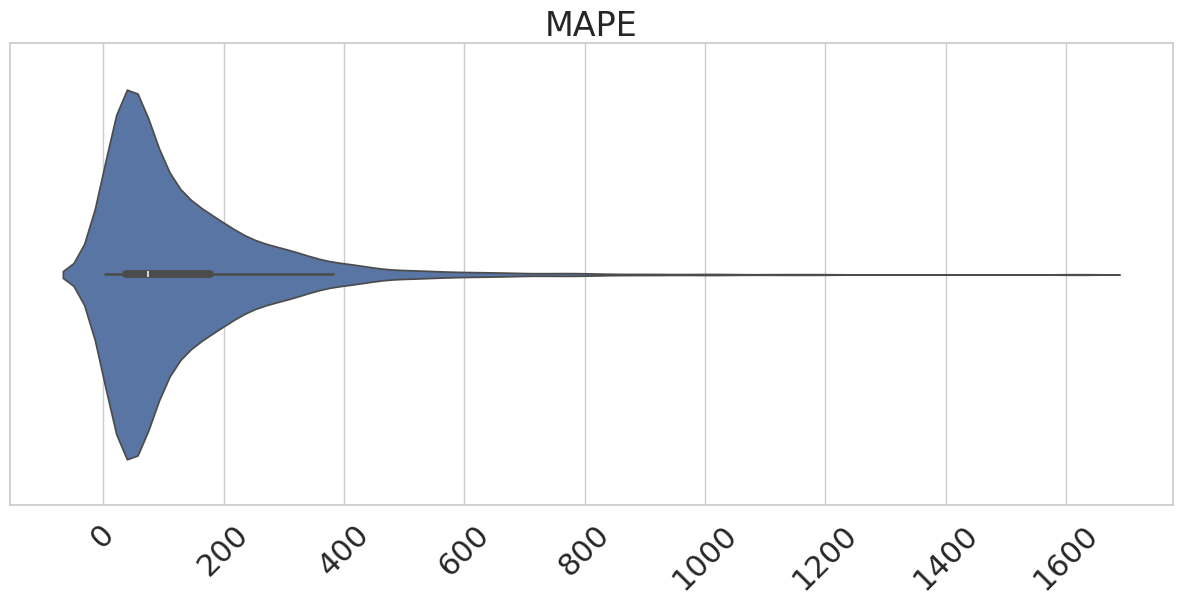

In [ ]:
metric = 'MAPE'

plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")
vp = sns.violinplot(x=metrics_df[metric])
vp.axes.set_title(metric)
sns.set(font_scale=2)
#plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10000000)) #RICORDA QUESTO
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(200)) #RICORDA QUESTO
vp.set_xlabel(None)

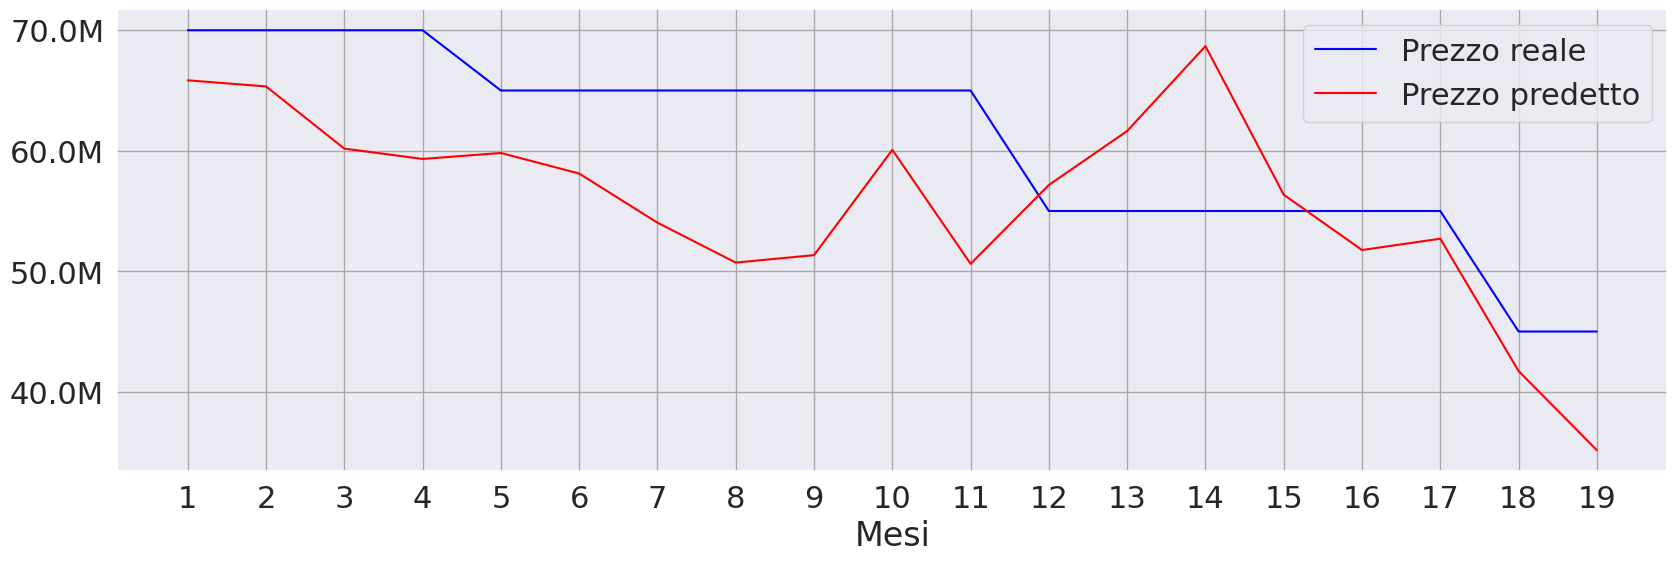

In [ ]:
player_id = 159471

results_player = results[results['player_id'] == player_id]
name = results.loc[results['player_id'] == player_id, 'name'].iloc[0]

plt.figure(figsize=(20, 6))

plt.plot(results_player.n_month, results_player.real_value, color='blue', label='Prezzo reale')
plt.plot(results_player.n_month, results_player.predicted_value, color='red', label='Prezzo predetto')

plt.xlabel("Mesi")

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
plt.xticks(results_player.n_month)

plt.grid(color='darkgrey')
plt.legend()
plt.show()